In [1]:
import os

In [2]:

import json

with open("examples.jsonl", "r") as f:
    examples = [json.loads(line) for line in f]


In [3]:
# Create train and test sets

from sklearn.model_selection import train_test_split

# Split examples into train and test sets, stratifying by label to maintain class distribution
train_examples, test_examples = train_test_split(
    examples,
    test_size=0.2, 
    random_state=42,
    stratify=[example["label"] for example in examples]
)

print(len(train_examples), len(test_examples))


541 136


In [4]:
CLASSES = ["animal", "location", "object", "person", "event"]

In [5]:
import numpy as np
import openai

client = openai.OpenAI()

def create_embeddings(examples) -> np.ndarray:
    embeddings = client.embeddings.create(input=examples, model="text-embedding-3-small")
    return np.array([embedding.embedding for embedding in embeddings.data])

# Make the embeddings

In [6]:
UNIQUE_CLASS_EMBEDDINGS = create_embeddings(CLASSES)

In [7]:
train_input_embeddings = create_embeddings([example["text"] for example in train_examples])
test_input_embeddings = create_embeddings([example["text"] for example in test_examples])

train_labels = [example["label"] for example in train_examples]
test_labels = [example["label"] for example in test_examples]

train_class_embeddings = create_embeddings(train_labels)
test_class_embeddings = create_embeddings(test_labels)



In [8]:
def calculate_cosine_similarity(embedding_1, embedding_2):
    return np.dot(embedding_1, embedding_2) / (np.linalg.norm(embedding_1) * np.linalg.norm(embedding_2))


# Method 1 : Direct projection


In [9]:

def classify_example(input_embedding):
    similarities = [calculate_cosine_similarity(input_embedding, class_embedding) for class_embedding in UNIQUE_CLASS_EMBEDDINGS]
    return np.argmax(similarities)

classify_example(train_input_embeddings[0])

np.int64(2)

In [37]:

train_results = [classify_example(train_input_embeddings[i]) == CLASSES.index(train_labels[i]) for i in range(len(train_examples))]
print("Train accuracy:", np.mean(train_results))

Train accuracy: 0.8133086876155268


In [41]:
results = []
print("Direct projection classification errors:")

for i, (embedding, label) in enumerate(zip(test_input_embeddings, test_labels)):
    prediction = classify_example(embedding)
    label_idx = CLASSES.index(label)
    correct =  classify_example(embedding) == label_idx
    results.append(correct)
    if not correct:
        print(test_examples[i]["text"], ":", label, "->", CLASSES[prediction])


print("\nTest accuracy:", np.mean(results))


Direct projection classification errors:
Drone : object -> animal
Ant : animal -> object
Frying Pan : object -> person
Rhino : animal -> object
Gavel : object -> event
Nile River : location -> animal
Sledge : object -> animal
Falconry : event -> animal
Ariana Grande : person -> animal
Eiffel Tower : location -> event
Nail Clippers : object -> animal
Photography Contest : event -> person
The Great Wall : location -> person
Kilimanjaro : location -> event
Chicago : location -> animal
Milan Cathedral : location -> object
Wireless Charger : object -> location
Pillow : object -> person
Victoria Falls : location -> event
Albert Einstein : person -> object
Gazelle : animal -> object
Waffle Maker : object -> event
Art Class : event -> object
Nice : location -> object
Leonardo da Vinci : person -> object

Test accuracy: 0.8161764705882353


Eyeballing these results, we can see that the naive embedding overlap approach is making some very obvious mistakes. Using this approach would be a disaster in a real-world application.

# Method 2: Using SVD to find the optimal rotation matrix


Evaluating SVD with 25 train examples and 6 components
Stonehenge: location -> event
Colosseum: location -> event
Falconry: event -> animal
Wolverine: animal -> person
Photography Contest: event -> object
Albert Einstein: person -> location
Bermuda: location -> animal
Film Premiere: event -> person
Nice: location -> object
Accuracy: 0.9338235294117647

Evaluating SVD with 50 train examples and 6 components
Falconry: event -> animal
Wolverine: animal -> person
Film Premiere: event -> person
Art Class: event -> object
Nice: location -> object
Accuracy: 0.9632352941176471

Evaluating SVD with 100 train examples and 6 components
Ant: animal -> object
Falconry: event -> animal
Art Class: event -> object
Nice: location -> object
Accuracy: 0.9705882352941176

Evaluating SVD with 200 train examples and 6 components
Ant: animal -> person
Falconry: event -> animal
Nice: location -> object
Accuracy: 0.9779411764705882

Evaluating SVD with 600 train examples and 6 components

Num parameters (unco

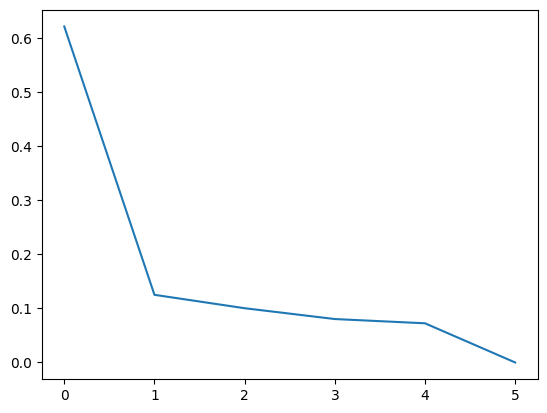

Num parameters (compressed): 18432
Ant: animal -> person
Falconry: event -> animal
Nice: location -> object
Accuracy: 0.9779411764705882
[np.float64(0.9338235294117647), np.float64(0.9632352941176471), np.float64(0.9705882352941176), np.float64(0.9779411764705882), np.float64(0.9779411764705882)]


In [78]:
import matplotlib.pyplot as plt
import torch

NUM_TRAIN_EXAMPLES = 100
CLASSES_EMBEDDINGS = torch.FloatTensor(UNIQUE_CLASS_EMBEDDINGS)


def run_svd(num_examples=None, num_components=None, plot=False):
    if num_examples is None:
        num_examples = len(train_input_embeddings)
    if num_components is None:
        num_components = train_input_embeddings.shape[1]
    # Convert embeddings to torch tensors for easier manipulation
    X = torch.FloatTensor(train_input_embeddings[:num_examples])
    # Get the target embeddings for each input example
    target_embeddings = CLASSES_EMBEDDINGS[
        torch.LongTensor(
            [CLASSES.index(label) for label in train_labels[:num_examples]]
        )
    ]

    # Compute the optimal transformation matrix
    # M = argmin ||MX - Y||_F where M is orthogonal
    C = target_embeddings.T @ X
    # print(C.shape)
    U, S, Vh = torch.linalg.svd(C)
    S_norm = S / S.sum()
    if plot:
        print()
        print("Num parameters (uncompressed):", U.numel())
        plt.plot(S_norm[0:num_components])
        plt.show()
    # Truncate to num_components
    U = U[:, :num_components]
    Vh = Vh[:num_components, :]

    if plot:
        print("Num parameters (compressed):", U.numel() + Vh.numel())
    M = U @ Vh
    return U, Vh


# TODO(hm): Vectorise this to use batches.


def classify_with_matrices(embedding, U, Vh):
    if not isinstance(embedding, torch.FloatTensor):
        embedding = torch.FloatTensor(embedding)
    if embedding.ndim == 1:
        embedding = embedding.unsqueeze(0)

    transformed = U @ Vh @ embedding.T
    similarities = torch.nn.functional.cosine_similarity(
        transformed.T.unsqueeze(1), CLASSES_EMBEDDINGS.unsqueeze(0), dim=2
    )
    return similarities.argmax().item()


def evaluate_svd(num_examples, num_components, plot=False):
    print(
        f"\nEvaluating SVD with {num_examples} train examples and {num_components} components"
    )
    U, Vh = run_svd(num_examples, num_components, plot)

    results = []
    for i, example in enumerate(test_examples):
        prediction = classify_with_matrices(test_input_embeddings[i], U, Vh)
        correct = prediction == CLASSES.index(example["label"])
        results.append(correct)
        if not correct:
            print(f"{example['text']}: {example['label']} -> {CLASSES[prediction]}")

    accuracy = np.mean(results)
    print(f"Accuracy: {accuracy}")
    return accuracy


num_components = 6

results = [
    evaluate_svd(
        num_examples=num_examples,
        num_components=num_components,
        plot=True if num_examples == 600 else False,
    )
    for num_examples in [25, 50, 100, 200, 600]
]
print(results)

In [76]:
U, Vh = run_svd(num_components=6)
results = []
for i, example in enumerate(train_examples):
    prediction = classify_with_matrices(train_input_embeddings[i], U, Vh)
    results.append(prediction == CLASSES.index(train_labels[i]))
    
print("Train accuracy:", np.mean(results))

Train accuracy: 0.9852125693160814


This results in 97.7% accuracy on the test set. This is a significant improvement over the direct projection approach, with the errors now looking more feasible.

```
Ant: animal -> person
Falconry: event -> animal
Nice: location -> object
```

- Ant (capitalised) is technically a person's name.
- Falconry is an event, but it's name is so similar to the animal that its misclassification is understandable. I imagine it's a relatively rare word too.
- Nice is a location, but it's name is so similar to the adjective that its misclassification is understandable without any context.

We can also see that the accuracy on the training set is 98.5% for 6 components. This indicates that the SVD approach is not overfitting, given by the small difference between the training and test accuracy. This is a good sign as we would like the approach to generalise well.

/var/folders/8r/43s7kjn14dvb88twkg_tx5h00000gn/T/ipykernel_40848/1842976041.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  input_transformed = Vh @ input_embeddings.T # (num_components, num_examples)
/var/folders/8r/43s7kjn14dvb88twkg_tx5h00000gn/T/ipykernel_40848/1842976041.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(np.abs(classes_transformed), label=CLASSES)


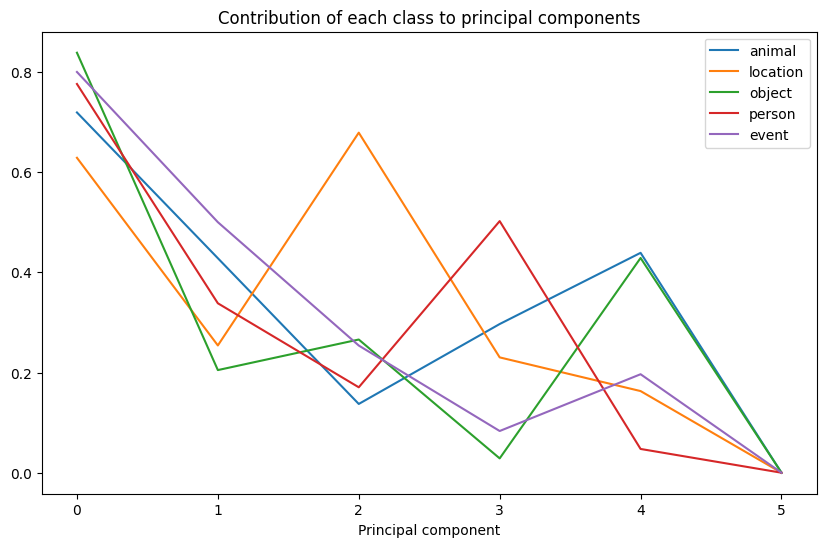

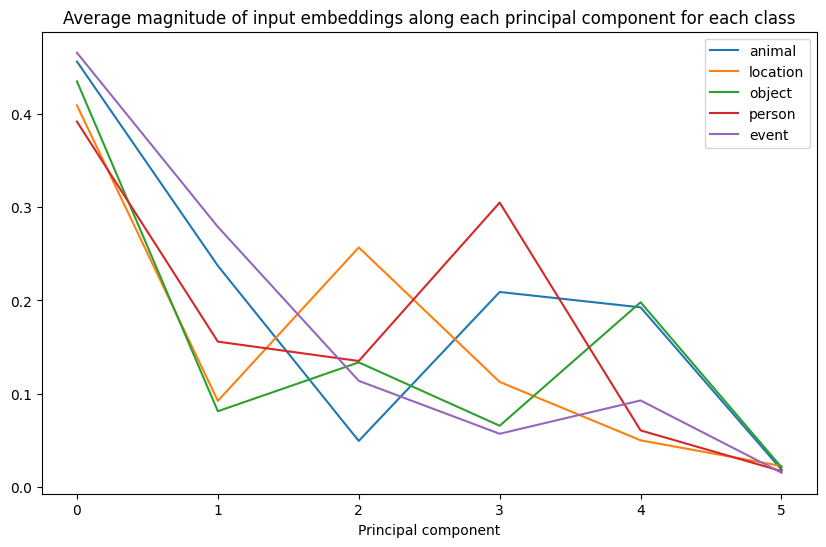


Class: animal
Dominant component: 2
Magnitudes per component: [0.45580186 0.23714365 0.04962724 0.20909424 0.19265384 0.01890665]

Class: location
Dominant component: 3
Magnitudes per component: [0.40887244 0.09247631 0.25679063 0.11281224 0.05028854 0.02277781]

Class: object
Dominant component: 5
Magnitudes per component: [0.43458779 0.08141847 0.1337331  0.06588231 0.19811878 0.02140699]

Class: person
Dominant component: 4
Magnitudes per component: [0.39153246 0.15593116 0.13518413 0.30479889 0.06089077 0.01733825]

Class: event
Dominant component: 2
Magnitudes per component: [0.46525021 0.27882503 0.11396892 0.05729809 0.09296533 0.0155956 ]


In [124]:
def classify_with_V_only(embedding, Vh):
    if not isinstance(embedding, torch.FloatTensor):
        embedding = torch.FloatTensor(embedding)
    if embedding.ndim == 1:
        embedding = embedding.unsqueeze(0)

    transformed = Vh @ embedding.T
    print(transformed.shape)
    print(transformed)
    # similarities = torch.nn.functional.cosine_similarity(
    #     transformed.T.unsqueeze(1), CLASSES_EMBEDDINGS.unsqueeze(0), dim=2
    # )
    # return similarities.argmax().item()

# print(test_examples[0])
# classify_with_V_only(test_input_embeddings[0], Vh)

def align_classes_to_components(input_embeddings, labels):
    """Analyze how different classes align with principal components"""
    
    # Transform the input embeddings X into the principal component space of X.
    # Each row corresponds to the magnitude of input embeddings along that principal axis in X.
    input_transformed = Vh @ input_embeddings.T # (num_components, num_examples)
    
    # Each row corresponds to the magnitude of class embeddings along that principal axis in Y.
    classes_transformed = U.T @ CLASSES_EMBEDDINGS.T # (num_components, num_classes)

    plt.figure(figsize=(10, 6))
    plt.plot(np.abs(classes_transformed), label=CLASSES)
    plt.title("Contribution of each class to principal components")
    plt.xlabel("Principal component")
    plt.legend()
    plt.show()

    class_alignments = {}
    
    if torch.is_tensor(input_transformed):
        input_transformed = input_transformed.numpy()
        
    plt.figure(figsize=(10, 6))
    plt.title("Average magnitude of input embeddings along each principal component for each class")
    plt.xlabel("Principal component")
    for class_name in CLASSES:
        class_indices = [i for i, label in enumerate(labels) if label == class_name]
        class_embeddings = input_transformed[:, class_indices]

        # Calculate average magnitude along each component
        component_magnitudes = np.abs(class_embeddings).mean(axis=1)
        plt.plot(component_magnitudes, label=class_name)
        # Store the dominant component (highest magnitude, excluding the first component which is uninformative)
        dominant_component = np.argmax(component_magnitudes[1:])
        class_alignments[class_name] = {
            'dominant_component': dominant_component + 2,
            'magnitude_per_component': component_magnitudes
        }
    plt.legend()
    plt.show()
    return class_alignments


alignments = align_classes_to_components(train_input_embeddings, train_labels)


for class_name, alignment in alignments.items():
    print(f"\nClass: {class_name}")
    print(f"Dominant component: {alignment['dominant_component']}")
    print("Magnitudes per component:", alignment['magnitude_per_component'])

Here we can see why it actually takes 6 principal components to capture the variation in the data. The first component explains over 60% of the variation of the data, and I imagine it amounts to some abstract meaning around noun-ness. 

# Method 3: Linear neural network

We will now remove the orthogonality constraint and train a linear classifier on the embeddings (without a bias term).


In [54]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# Define the neural network
class LinearClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim, bias=False)
        self.register_buffer(
            "output_proj", torch.FloatTensor(UNIQUE_CLASS_EMBEDDINGS), persistent=False
        )

    def forward(self, x):
        output = self.linear(x)
        output = output @ self.output_proj.T
        return output


# Create dataset class
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor([CLASSES.index(label) for label in labels])

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


# Input embeddings: each row is an embedding of length 1536
dataset = EmbeddingDataset(train_input_embeddings, train_labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
model = LinearClassifier(input_dim=train_input_embeddings.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 1000
prev_loss = 1e10
tol = 1e-3
for epoch in range(num_epochs):
    total_loss = 0
    for batch_embeddings, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")
        if abs(total_loss - prev_loss) < tol:
            print("Loss converged, stopping early")
            break
        prev_loss = total_loss


def classify_example_with_nn(embedding):
    model.eval()
    with torch.no_grad():
        output = model(torch.FloatTensor(embedding))
        return torch.argmax(output).item()

results = []
for i, example in enumerate(train_examples):
    prediction = classify_example_with_nn(train_input_embeddings[i])
    results.append(prediction == CLASSES.index(train_labels[i]))
    
print("Train accuracy:", np.mean(results))

print("\nTesting on examples:")
results = []
for i, example in enumerate(test_examples):
    prediction = classify_example_with_nn(test_input_embeddings[i])
    correct = prediction == CLASSES.index(example["label"])
    results.append(correct)
    if not correct:
        print(f"{example['text']}: {example['label']} -> {CLASSES[prediction]}")

print("Accuracy:", np.mean(results))

Epoch [10/1000], Loss: 0.0137
Epoch [20/1000], Loss: 0.0044
Epoch [30/1000], Loss: 0.0021
Epoch [40/1000], Loss: 0.0012
Epoch [50/1000], Loss: 0.0008
Epoch [60/1000], Loss: 0.0005
Epoch [70/1000], Loss: 0.0003
Epoch [80/1000], Loss: 0.0002
Epoch [90/1000], Loss: 0.0002
Epoch [100/1000], Loss: 0.0001
Epoch [110/1000], Loss: 0.0001
Epoch [120/1000], Loss: 0.0001
Epoch [130/1000], Loss: 0.0000
Epoch [140/1000], Loss: 0.0000
Loss converged, stopping early
Train accuracy: 1.0

Testing on examples:
Falconry: event -> animal
Gazelle: animal -> object
Nice: location -> object
Accuracy: 0.9779411764705882


Remarkably, this results in the exact same accuracy on the test set. 

It gets Ant correct this time, but still misclassifies Falconry and Nice, as well 

```
Gazelle: animal -> object
```

This is understandable, as Gazelle are also a type of Adidas shoe!


It's interesting to see that the linear NN gets an training accuracy of 100%. This could indicate some overfitting. The nice thing about the rotation matrix approach is that we don't really need to worry about overfitting. There is regularization built-in through the inductive bias of the orthogonal transformation.